# Traffic Jam - Predicting People's Movement into Nairobi

We'll create a predictive model using traffic data provided from Uber Movement and historic bus ticket sales data from Mobiticket to predict the number of tickets that will be sold for buses into Nairobi from cities in "up country" Kenya.


In [406]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
plt.style.use('fivethirtyeight')

### 1. Data

In [407]:
df = pd.read_csv(r'C:\Users\Patrick Munene\Documents\Machine Learning\Zindi - Traffic Jam\data\train_aggregated.csv')

In [408]:
df.head()

,travel_date,travel_time,travel_from,max_capacity,number_of_tickets,year,month,day
0,1,435,9,49,1.0,2017,10,17
1,6,432,9,49,1.0,2017,11,19
2,6,425,4,49,1.0,2017,11,26
3,0,430,1,49,5.0,2017,11,27
4,0,432,9,49,31.0,2017,11,27


Checking the data

In [409]:
df.isnull().sum()

travel_date          0
travel_time          0
travel_from          0
max_capacity         0
number_of_tickets    0
year                 0
month                0
day                  0
dtype: int64

In [410]:
df.dtypes

travel_date            int64
travel_time            int64
travel_from            int64
max_capacity           int64
number_of_tickets    float64
year                   int64
month                  int64
day                    int64
dtype: object

The data looks clean. So we can start with the analysis.

# Basic EDA

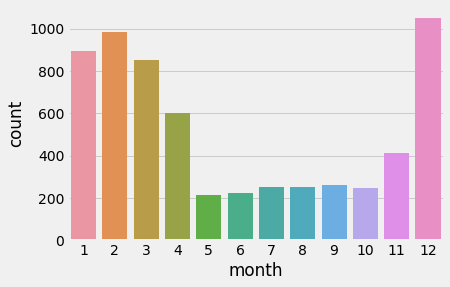

In [411]:
sns.countplot(x='month',data=df)
plt.show()

# Feature Engineering


In [412]:
import featuretools as ft

# Finding Important Features¶


We're going to let scikit-learn help us determine which variables are the best at predicting number of tickets using RandomForest.

In [413]:
from sklearn.ensemble import RandomForestClassifier

features = np.array(['travel_date','travel_time','travel_from',
                     'max_capacity','year','month','day'])
clf = RandomForestClassifier()
clf.fit(df[features], df['number_of_tickets'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [414]:
# from the calculated importances, order them from most to least important
# and make a barplot so we can visualize what is/isn't important
importances = clf.feature_importances_
sorted_idx = np.argsort(importances)

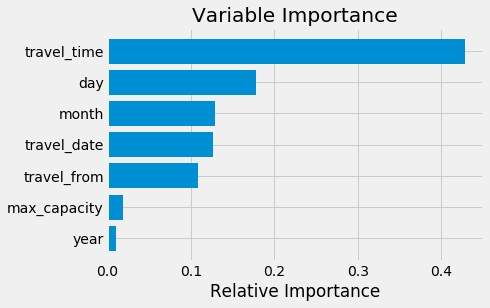

In [415]:
padding = np.arange(len(features)) + 0.5
plt.barh(padding, importances[sorted_idx], align='center')
plt.yticks(padding, features[sorted_idx])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

# Interpretting the results

## Feature

In [416]:
def calculate_time_period(travel_time):
    time_period = travel_time / 60
    return time_period

df['time_period'] = np.ceil(df.travel_time.apply(calculate_time_period))

In [417]:
df.head()

,travel_date,travel_time,travel_from,max_capacity,number_of_tickets,year,month,day,time_period
0,1,435,9,49,1.0,2017,10,17,8.0
1,6,432,9,49,1.0,2017,11,19,8.0
2,6,425,4,49,1.0,2017,11,26,8.0
3,0,430,1,49,5.0,2017,11,27,8.0
4,0,432,9,49,31.0,2017,11,27,8.0


In [418]:
# bins = [0, 9, 18, 24]
# names = ['morning', 'day', 'night']

# df['period'] = pd.cut(df.time_period, bins, labels=names)

In [419]:
def func(time_period):
    if time_period['time_period'] > 4 and time_period['time_period'] <= 9:
        return 'early_morning'
    elif time_period['time_period'] > 9 and time_period['time_period'] <= 16:
        return 'day'     
    elif time_period['time_period'] > 16 and time_period['time_period'] <= 24:
        return 'night'  
    else:
        return 'other'

df['day_night'] = df.apply(func, axis=1)

In [420]:
#len(df.day_night.unique())

In [421]:
df.drop(['year'], axis=1, inplace=True) 

In [422]:
df.tail()

,travel_date,travel_time,travel_from,max_capacity,number_of_tickets,month,day,time_period,day_night
6244,4,1390,10,49,11.0,4,20,24.0,night
6245,4,425,10,49,11.0,4,20,8.0,early_morning
6246,4,429,14,49,1.0,4,20,8.0,early_morning
6247,4,480,0,49,1.0,4,20,8.0,early_morning
6248,1,310,7,49,1.0,11,14,6.0,early_morning


In [423]:
df["day_night"] = pd.Categorical(df["day_night"])
day_night_categories = df.day_night.cat.categories
df["day_night"] = df.day_night.cat.codes

In [424]:
df.tail()

,travel_date,travel_time,travel_from,max_capacity,number_of_tickets,month,day,time_period,day_night
6244,4,1390,10,49,11.0,4,20,24.0,2
6245,4,425,10,49,11.0,4,20,8.0,1
6246,4,429,14,49,1.0,4,20,8.0,1
6247,4,480,0,49,1.0,4,20,8.0,1
6248,1,310,7,49,1.0,11,14,6.0,1


So you can see that the best variable is travel_time while the worst is car_type. There's also a dramatic drop off after travel_date. This is where we need to use our own discretion. How many variables should we include in the model?

# Bucketing Continuous Values

Sometimes turning a continuous feature (infinite number of possible values) into a discrete feature (fixed number of possibel values) can make all the different in the world in terms of how valueable it is. Take for instance elementary school grades. Instead of using a numerical scale, such as 0%-100%, converting that to a letter grade, "A, B, C, D, F" might make a lot more sense when evaluating elementary school students.

In [425]:
df['day_bins'] = pd.cut(df.day, bins=7, labels=False)
pd.value_counts(df.day)

2     706
12    685
3     659
4     446
1     267
13    249
14    247
16    238
28    228
18    226
19    226
15    213
17    209
20    202
22    192
21    183
27    179
29    177
23    159
24    137
26    120
30    113
25     96
31     92
Name: day, dtype: int64

In [426]:
df.head()

,travel_date,travel_time,travel_from,max_capacity,number_of_tickets,month,day,time_period,day_night,day_bins
0,1,435,9,49,1.0,10,17,8.0,1,3
1,6,432,9,49,1.0,11,19,8.0,1,4
2,6,425,4,49,1.0,11,26,8.0,1,5
3,0,430,1,49,5.0,11,27,8.0,1,6
4,0,432,9,49,31.0,11,27,8.0,1,6


# Inspecting the predictive value of your bins

A quick and dirty way to see the effectiveness of derived bins is to inspect their distribution as it relates to the variable you're predicting. For us that means cross-tablulating it against number_of_tickets.

In this case, it's very easy to see in the plot that number_of_tickets tends to be higher where the day_bin are lower.

In [427]:
df[["day", "number_of_tickets"]].groupby("day").mean()

,number_of_tickets
day,
1,8.299625
2,7.995751
3,8.924127
4,8.542601
12,8.035036
13,9.365462
14,8.842105
15,8.830986
16,8.210084


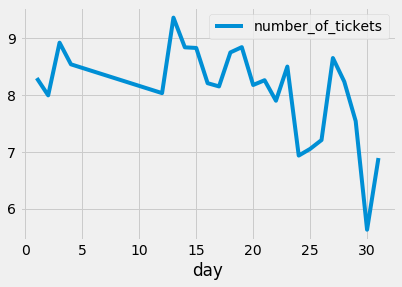

In [428]:
cols = ["day", "number_of_tickets"]
df[cols].groupby("day").mean().plot()

# Transformation  

In [429]:
df.dtypes

travel_date            int64
travel_time            int64
travel_from            int64
max_capacity           int64
number_of_tickets    float64
month                  int64
day                    int64
time_period          float64
day_night               int8
day_bins               int64
dtype: object

In [430]:
#natural log of travel_time
log_day = np.log(df[['day']].values).astype('float32')
df['log_day'] = log_day

##natural log of travel_from
#travel_from_ratio = np.log(df[['travel_time']]/df[['travel_from']].values).astype('float64')
#df['travel_from_ratio'] = travel_from_ratio

In [431]:
df.tail()

,travel_date,travel_time,travel_from,max_capacity,number_of_tickets,month,day,time_period,day_night,day_bins,log_day
6244,4,1390,10,49,11.0,4,20,24.0,2,4,2.995732
6245,4,425,10,49,11.0,4,20,8.0,1,4,2.995732
6246,4,429,14,49,1.0,4,20,8.0,1,4,2.995732
6247,4,480,0,49,1.0,4,20,8.0,1,4,2.995732
6248,1,310,7,49,1.0,11,14,6.0,1,3,2.639057


In [432]:
df.isnull().sum()

travel_date          0
travel_time          0
travel_from          0
max_capacity         0
number_of_tickets    0
month                0
day                  0
time_period          0
day_night            0
day_bins             0
log_day              0
dtype: int64

## Let's Do Some Predictive Modeling

In [433]:
from sklearn import svm
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

### Stratification:
When we split the dataset into train and test datasets, the split is completely random. Thus the instances of each class label or outcome in the train or test datasets is random. Thus we may have many instances of class 1 in training data and less instances of class 2 in the training data. So during classification, we may have accurate predictions for class1 but not for class2. Thus we stratify the data, so that we have proportionate data for all the classes in both the training and testing data.

In [434]:
df.head()

,travel_date,travel_time,travel_from,max_capacity,number_of_tickets,month,day,time_period,day_night,day_bins,log_day
0,1,435,9,49,1.0,10,17,8.0,1,3,2.833213
1,6,432,9,49,1.0,11,19,8.0,1,4,2.944439
2,6,425,4,49,1.0,11,26,8.0,1,5,3.258096
3,0,430,1,49,5.0,11,27,8.0,1,6,3.295837
4,0,432,9,49,31.0,11,27,8.0,1,6,3.295837


In [435]:
X = df.drop(["number_of_tickets"], axis=1)
X.head()

,travel_date,travel_time,travel_from,max_capacity,month,day,time_period,day_night,day_bins,log_day
0,1,435,9,49,10,17,8.0,1,3,2.833213
1,6,432,9,49,11,19,8.0,1,4,2.944439
2,6,425,4,49,11,26,8.0,1,5,3.258096
3,0,430,1,49,11,27,8.0,1,6,3.295837
4,0,432,9,49,11,27,8.0,1,6,3.295837


In [436]:
y = df.number_of_tickets.astype('float32')
y.head()

0     1.0
1     1.0
2     1.0
3     5.0
4    31.0
Name: number_of_tickets, dtype: float32

In [437]:
#Split the dataset into train and Test
seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# XGboost Classification

In [438]:
#Train the XGboost Model for Classification
model = xgb.XGBClassifier(n_estimators=100, 
                          max_depth=8, 
                          learning_rate=0.1, 
                          subsample=0.5)

In [439]:
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

In [440]:
preds_train_set = model.predict(X_test)

In [441]:
print (mean_absolute_error(preds_train_set,y_test))

3.7882278


# Random forest model

In [442]:
model2 = RandomForestRegressor(n_estimators=100, 
                               criterion="mae", 
                               n_jobs=-1)

In [443]:
model2.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [444]:
preds2_train_set = model2.predict(X_test)

In [445]:
print (mean_absolute_error(preds2_train_set,y_test))

3.3722392834293022


# Support Vector Machine

In [446]:
from sklearn.svm import SVC
model3 = SVC(kernel = 'linear', C = 0.025, random_state = 101)

In [447]:
model3.fit(X_train, y_train)

SVC(C=0.025, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=101, shrinking=True,
  tol=0.001, verbose=False)

In [448]:
model3.score(X, y)

0.2634021443430949

In [449]:
preds3_train_set = model3.predict(X_test)

In [450]:
print (mean_absolute_error(preds3_train_set,y_test))

6.7581573


# kNN (k- Nearest Neighbors)

In [451]:
from sklearn.neighbors import KNeighborsClassifier
model4 = KNeighborsClassifier(n_neighbors=6)

In [452]:
model4.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6, p=2,
           weights='uniform')

In [453]:
preds4_train_set= model4.predict(X_test)

In [454]:
print (mean_absolute_error(preds4_train_set,y_test))

4.550224


# Catboost

In [455]:
from catboost import CatBoostRegressor
model5=CatBoostRegressor(iterations=5000, depth=3, learning_rate=0.1, loss_function='RMSE', silent=True)

In [456]:
model5.fit(X, y)

In [457]:
preds5_train_set= model5.predict(X_test)

In [458]:
print (mean_absolute_error(preds5_train_set,y_test))

3.4723165399942983


# GBM

In [459]:
from sklearn.ensemble import GradientBoostingClassifier

In [460]:
model6 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

In [461]:
model6.fit(X, y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=1.0, loss='deviance', max_depth=1,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=0, subsample=1.0, verbose=0,
              warm_start=False)

In [462]:
preds6_train_set= model6.predict(X_test)

In [463]:
print (mean_absolute_error(preds6_train_set,y_test))

6.356366


# Predictions for test set

In [464]:
df_test_set = pd.read_csv(r'C:\Users\Patrick Munene\Documents\Machine Learning\Zindi - Traffic Jam\data\test_questions.csv', 
                          low_memory=False)

Let's first format the data as we did for the training set.

In [465]:
df_test_set['year'] = pd.DatetimeIndex(df_test_set['travel_date']).year
df_test_set['month'] = pd.DatetimeIndex(df_test_set['travel_date']).month
df_test_set['day'] = pd.DatetimeIndex(df_test_set['travel_date']).day

In [466]:
df_test_set.drop(['travel_to','car_type'], axis=1, inplace=True)

In [467]:
df_test_set.head()

,ride_id,travel_date,travel_time,travel_from,max_capacity,year,month,day
0,247,2018-05-07,07:06,Kisii,49,2018,5,7
1,256,2018-05-06,11:08,Kisii,11,2018,5,6
2,275,2018-05-04,05:00,Kisii,11,2018,5,4
3,285,2018-05-04,09:10,Kisii,11,2018,5,4
4,286,2018-05-04,09:20,Kisii,11,2018,5,4


In [468]:
df_test_set["travel_date"] = pd.to_datetime(df_test_set["travel_date"],infer_datetime_format=True)
df_test_set["travel_date"] = df_test_set["travel_date"].dt.dayofweek

In [469]:
df_test_set["travel_from"] = pd.Categorical(df_test_set["travel_from"])
travel_from_categories = df_test_set.travel_from.cat.categories
df_test_set["travel_from"] = df_test_set.travel_from.cat.codes

In [470]:
df_test_set["travel_time"] = df_test_set["travel_time"].str.split(':').apply(lambda x: int(x[0]) * 60 + int(x[1]))

In [471]:
def calculate_time_period(travel_time):
    time_period = travel_time / 60
    return time_period

df_test_set['time_period'] = np.ceil(df_test_set.travel_time.apply(calculate_time_period))

def func(time_period):
    if time_period['time_period'] > 4 and time_period['time_period'] <= 9:
        return 'early_morning'
    elif time_period['time_period'] > 9 and time_period['time_period'] <= 16:
        return 'day'     
    elif time_period['time_period'] > 16 and time_period['time_period'] <= 24:
        return 'night'  
    else:
        return 'other'

df_test_set['day_night'] = df_test_set.apply(func, axis=1)

df_test_set.drop(['year'], axis=1, inplace=True) 

df_test_set["day_night"] = pd.Categorical(df_test_set["day_night"])
day_night_categories = df_test_set.day_night.cat.categories
df_test_set["day_night"] = df_test_set.day_night.cat.codes

In [472]:
df_test_set.head()

,ride_id,travel_date,travel_time,travel_from,max_capacity,month,day,time_period,day_night
0,247,0,426,5,49,5,7,8.0,1
1,256,6,668,5,11,5,6,12.0,0
2,275,4,300,5,11,5,4,5.0,1
3,285,4,550,5,11,5,4,10.0,0
4,286,4,560,5,11,5,4,10.0,0


In [473]:
df_test_set['day_bins'] = pd.cut(df.day, bins=7, labels=False)
pd.value_counts(df.day)

2     706
12    685
3     659
4     446
1     267
13    249
14    247
16    238
28    228
18    226
19    226
15    213
17    209
20    202
22    192
21    183
27    179
29    177
23    159
24    137
26    120
30    113
25     96
31     92
Name: day, dtype: int64

In [474]:
log_day = np.log(df_test_set[['day']].values).astype('float32')
df_test_set['log_day'] = log_day

In [475]:
df_test_set.head()

,ride_id,travel_date,travel_time,travel_from,max_capacity,month,day,time_period,day_night,day_bins,log_day
0,247,0,426,5,49,5,7,8.0,1,3,1.945910
1,256,6,668,5,11,5,6,12.0,0,4,1.791759
2,275,4,300,5,11,5,4,5.0,1,5,1.386294
3,285,4,550,5,11,5,4,10.0,0,6,1.386294
4,286,4,560,5,11,5,4,10.0,0,6,1.386294


Now let's calculate predictions using the best model we trained.

In [476]:
X_test = df_test_set.drop(['ride_id'], axis=1)
test_set_predictions = model5.predict(X_test)

And finally let's create a csv file with predictions.

In [477]:
d = {'ride_id': df_test_set["ride_id"], 'number_of_ticket': test_set_predictions}
df_predictions = pd.DataFrame(data=d)
df_predictions = df_predictions[['ride_id','number_of_ticket']]

In [478]:
df_predictions.head()

,ride_id,number_of_ticket
0,247,2.663245
1,256,-0.522005
2,275,1.412050
3,285,2.236873
4,286,2.238162


In [479]:
#save to csv file
df_predictions.to_csv(r'C:\Users\Patrick Munene\Documents\Machine Learning\Zindi - Traffic Jam\data\preds_test_set.csv', index=False)